In [3]:
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
try:
    del sys.modules["lgpgm"]
except:
    pass
from lgpgm import noise
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.algorithms.Marginalization import marginalize
from spn.algorithms.Inference import likelihood 
import scipy.stats as stats

In [4]:
"eps" @ noise

eps ~ N(0.0, 1.0)

In [5]:
X = "X" @ (sqrt(2)*noise + 1)
Y = "Y" @ (0.5*X + sqrt(0.5) * noise + 0.5)
print(X)
print(Y)     # PGM: X -> Y

X ~ N(1.0, 2.0)
Y ~ N(1.0, 1.0)


In [6]:
X.condition(0) # observe X=0
print(X) # is now a constant node
print(Y) # is now the conditional distribution of Y given X=0
X.condition(None) # unobserve X

X ~ N(0.0, 0.0)
Y ~ N(0.5, 0.5)


In [10]:
print("scope:", X.get_scope())
print("mean:")
display(X.get_μ())
print("covariance:")
display(X.get_Σ())

scope: ['X', 'Y']
mean:


X    1.0
Y    1.0
dtype: float64

covariance:


,X,Y
X,2.0,1.0
Y,1.0,1.0


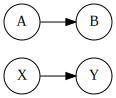

In [13]:
A = "A" @ (noise + 0.3)
B = "B" @ (-0.3*A * 2 + 0.1*noise - 0.5)
# C = "C" @ (0.5*B + 0.5*Y + 0.1*noise)

A & X

A.get_BN_graph()

In [16]:
print("new scope:", A.get_scope())
print("new mean:")
print(A.get_μ())
print("new covariance:")
print(A.get_Σ())

new scope: ['A', 'B']
new mean:
A    0.30
B   -0.68
dtype: float64
new covariance:
     A     B
A  1.0 -0.60
B -0.6  0.37


In [19]:
samples = A.sample(100)
print(samples["B"].describe())

count    100.000000
mean      -0.712456
std        0.603131
min       -2.070437
25%       -1.087661
50%       -0.754980
75%       -0.315962
max        0.899496
Name: B, dtype: float64


In [ ]:
# making a new clg with same structure but standard params to fit.
A, X = "A" @ noise, "X" @ noise
"B" @ A
"Y" @ X
clg2 = CLG([A, X])
clg2.show_graph()
clg2.learn_params(samples)
print("learned mean:")
print(clg2.get_μ())
print("learned covariance:")
print(clg2.get_Σ().round(4))
print("uninformed covariance:")
index = ["X", "A", "Y", "B"]
print(samples.cov().round(4)[["X", "A", "Y", "B"]].reindex(["X", "A", "Y", "B"]))

learned mean:
A    0.309040
X    0.779920
B   -0.199684
Y    1.293147
dtype: float64
learned covariance:
        A       X       B       Y
A  0.9685  0.0000 -0.5824  0.0000
X  0.0000  2.4492  0.0000  1.1439
B -0.5824  0.0000  0.3589  0.0000
Y  0.0000  1.1439  0.0000  1.0242
uninformed covariance:
        X       A       Y       B
X  2.4492 -0.0140  1.1439  0.0094
A -0.0140  0.9685  0.0307 -0.5824
Y  1.1439  0.0307  1.0242 -0.0147
B  0.0094 -0.5824 -0.0147  0.3589


### immorality covariance

    P0  P1  P2  A   X   B   C   D   E   Y   Z 
P0   0   0   0   0   0   0   0   0   0   0   0
P1   0   0   0   0   0   0   0   0   0   0   0
P2   0   0   0   0   0   0   0   0   0   0   0
A    0   0   0   0   0   0   0   0   0   0   0
X    0   0   0   0   0   0   0   0   0   0   0
B    0   0   0   0   0   0   0   0   0   0   0
C    0   0   0   0   0   0   0   0   0   0   0
D    0   0   0   0   0   0   0   0   0   0   0
E    0   0   0   0   0   0   0   0   0   0   0
Y    0   0   0   0   0   0   0   0   0   0   0
Z    0   0   0   0   0   0   0   0   0   0   0


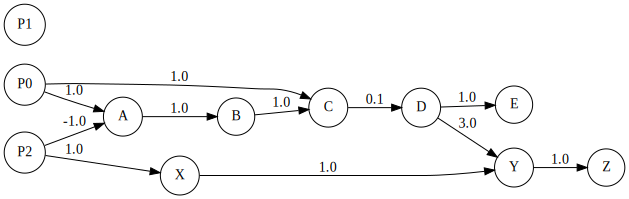

In [ ]:
P0 = "P0" @ (noise)
P1 = "P1" @ (noise) 
P2 = "P2" @ (noise)
A = "A " @ (P0 - P2)
X = "X " @ (P2)
B = "B " @ (A)
C = "C " @ (B + P0)
D = "D " @ (0.1*C + noise)
E = "E " @ (D + noise)
Y = "Y " @ (X + 3*D + noise)
Z = "Z " @ (Y)

clg = CLG([ P0, P1, P2])
true_cov = clg.get_Σ()
# print(true_cov)
sampled_cov = pd.DataFrame(np.cov(clg.forward_sample(10000), rowvar=False), index=clg.get_scope(), columns=clg.get_scope())
print((sampled_cov - true_cov).round().astype(int))
clg.show_graph()

    A   X   B   Y   O 
A    1   0   1   0   1
X    0   1   0   1   1
B    1   0   2   0   2
Y    0   1   0   2   2
O    1   1   2   2   5
    A   X   B   Y   O 
A    0   0   0   0   0
X    0   0   0   0   0
B    0   0   0   0   0
Y    0   0   0   0   0
O    0   0   0   0   0


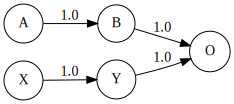

In [ ]:

A = "A " @ (noise)
B = "B " @ (A + noise)
X = "X " @ (noise)
Y = "Y " @ (X + noise)
O = "O " @ (B + Y + noise)


clg = CLG([A, X])
true_cov = clg.get_Σ().round().astype(int)
print(true_cov)
sampled_cov = pd.DataFrame(np.cov(clg.forward_sample(1000), rowvar=False).round().astype(int), index=clg.get_scope(), columns=clg.get_scope())
print((sampled_cov - true_cov))
clg.show_graph()

    A   B   X 
A    1   2   3
B    2   5   7
X    3   7  11
    A   B   X 
A    0   0   0
B    0   0   0
X    0   0   0


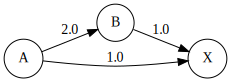

In [ ]:

A = "A " @ (noise)
B = "B " @ (2 * A + noise)
X = "X " @ (A + B + noise)


clg = CLG([A])
true_cov = clg.get_Σ().round().astype(int)
print(true_cov)
sampled_cov = pd.DataFrame(np.cov(clg.forward_sample(10000), rowvar=False).round().astype(int), index=clg.get_scope(), columns=clg.get_scope())
print((sampled_cov - true_cov))
clg.show_graph()